# Анализ бизнеса GoFast

***

### Задача:

GoFast - сервис аренды самокатов. Есть данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Необходимо проанализировать данные и проверить некоторые предложенные гипотезы, которые могут помочь бизнесу вырасти.

Гипотезы:

 1) Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

 2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

 3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?
 
***

### Описание проекта и данных:

Чтобы совершать поездки по городу, пользователи сервиса GoFast пользуются мобильным приложением. Сервисом можно пользоваться:
* без подписки
  * абонентская плата отсутствует;
  * стоимость одной минуты поездки — 8 рублей;
  * стоимость старта (начала поездки) — 50 рублей;
* с подпиской Ultra
    * абонентская плата — 199 рублей в месяц;
    * стоимость одной минуты поездки — 6 рублей;
    * стоимость старта — бесплатно.
    
Данные о пользователях в файле `users_go.csv`:
* `user_id` - уникальный идентификатор пользователя
* `name` - имя пользователя
* `age` - возраст
* `city` - город
* `subscription_type` - тип подписки (free, ultra)

Данные о поездках в файле `rides_go.csv`:
* `user_id` - уникальный идентификатор пользователя
* `distance` - расстояние, которое пользователь проехал в текущей сессии (в метрах)
* `duration` - продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
* `date` - дата совершения поездки

Данные о подписке в файле `subscriptions_go.csv`:

* `subscription_type` - тип подписки
* `minute_price` - стоимость одной минуты поездки по данной подписке
* `start_ride_price` - стоимость начала поездки
* `subscription_fee` - стоимость ежемесячного платежа

***

### План работ:

**[Шаг 1.](#section_1)** Загрузка данных, изучение общей информации о каждом датафрейме.

**[Шаг 2.](#section_2)** Предобработка данных.

**[Шаг 3.](#section_3)** Проведем анализ информации о пользователях и поездках: частота встречаемости городов; соотношение пользователей с подпиской и без подписки;возраст пользователей; расстояние, которое пользователь преодолел за одну поездку;продолжительность поездок и др.

**[Шаг 4.](#section_4)** Проведем анализ гипотез.

**[Шаг 5.](#section_5)** Решим доп.задачу для заказчика: Найдем минимальное количество промокодов для акции.

**[Шаг 6.](#section_6)** Общий вывод.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats as st
from math import sqrt
from scipy.stats import binom, norm

<a id='section_1'></a>
### Шаг 1. Загрузка данных, изучение общей информации о каждом датафрейме

In [2]:
#Сохраняем данные в датафреймы
users = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/2/users_go.csv')
rides = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/2/rides_go.csv')
subscriptions = pd.read_csv('C:/Users/ratus/DATA_SCIENCE/итоговые проекты/2/subscriptions_go.csv')

In [3]:
#Общая информация по датафрейму
users.info()

#Несколько строк датафрейма
users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
#Общая информация по датафрейму
rides.info()

#Несколько строк датафрейма
rides.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [5]:
#Общая информация по датафрейму
subscriptions.info()

#Несколько строк датафрейма
subscriptions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


В полученных данных содержится информация о 18068 поездках от 1565 пользователей.

Данные не содержат пропусков, с названиями столбцов тоже все ок. 

Нужно бы поменять тип данных столбца `date` на datetime.

<a id='section_2'></a>
### Шаг 2. Предобработка данных

Приведем столбец `date` из датафрейма поездок к типу даты  

In [6]:
#Изменяем тип
rides['date'] = pd.to_datetime(
    rides['date'], format = '%Y-%m-%d'
)

Создадим новые столбцы с номером месяца и годом на основе столбца date

In [7]:
rides['month'] = rides['date'].dt.month

#Проверяем
print (display(rides.head()))

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


None


In [8]:
rides['year'] = rides['date'].dt.year

#Проверяем
print (display(rides.head()))

,user_id,distance,duration,date,month,year
0,1,4409.919140,25.599769,2021-01-01,1,2021
1,1,2617.592153,15.816871,2021-01-18,1,2021
2,1,754.159807,6.232113,2021-04-20,4,2021
3,1,2694.783254,18.511000,2021-08-11,8,2021
4,1,4028.687306,26.265803,2021-08-28,8,2021


None


Посмотрим данные за сколько лет мы имеем:

In [9]:
rides['year'].unique()

array([2021], dtype=int64)

Все поездки совершены за 2021год.

Проверим наличие пропущенных значений и дубликатов в датафреймах. Обработаем их, если такие значения будут присутствовать

In [10]:
#Найдем кол-во пропусков для каждого признака
users.isna().sum().sort_values(ascending=False)

user_id              0
name                 0
age                  0
city                 0
subscription_type    0
dtype: int64

In [11]:
#Найдем кол-во пропусков для каждого признака
rides.isna().sum().sort_values(ascending=False)

user_id     0
distance    0
duration    0
date        0
month       0
year        0
dtype: int64

In [12]:
#Найдем кол-во пропусков для каждого признака
subscriptions.isna().sum().sort_values(ascending=False)

subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

Пропущенных значений в датафреймах нет.

In [13]:
#Ищем дубликаты по всему датафрейму
users.duplicated().sum()

31

В датафрейме пользователей обнаружено 31 строк дубликатов, удалим их:

In [14]:
users = users.drop_duplicates().reset_index(drop=True)

In [15]:
#Ищем дубликаты по всему датафрейму
rides.duplicated().sum()

0

In [16]:
#Ищем дубликаты по параметрам
rides[rides.duplicated(['user_id', 'distance','date'])]

,user_id,distance,duration,date,month,year


In [17]:
#Ищем дубликаты по параметрам
rides[rides.duplicated(['user_id', 'duration','date'])]

,user_id,distance,duration,date,month,year


В датафрейме `rides` дубликатов строк нет. Дубликатов поездок по подмножествам тоже нет.

In [18]:
#Ищем дубликаты по всему датафрейму
subscriptions.duplicated().sum()

0

В датафрейме подписок дубликатов нет.

<a id='section_3'></a>
### Шаг 3. Исследовательский анализ данных

Опишем и визуализируем общую информацию о пользователях и поездках

#### 3.1 Посмотрим частоту встречаемости городов

In [19]:
users['city'].value_counts().to_frame()

,city
Пятигорск,219
Екатеринбург,204
Ростов-на-Дону,198
Краснодар,193
Сочи,189
Омск,183
Тюмень,180
Москва,168


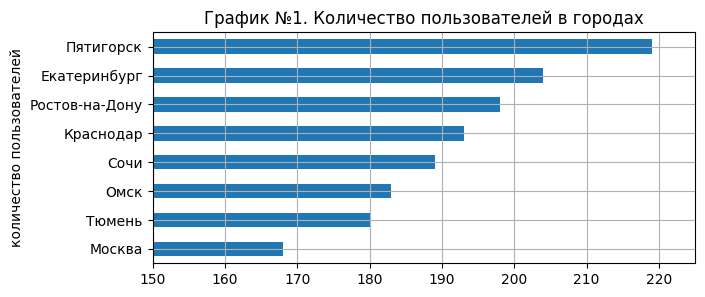

In [20]:
users['city'].value_counts().sort_values().plot.barh(
    xlim=(150,225), 
    figsize = (7,3),
    grid = True,
    title = 'График №1. Количество пользователей в городах',
    xlabel = 'количество пользователей',
    ylabel = 'город'
);

Больше всего пользователей в Пятигорске - 219 и меньше всего в Москве - 168.

#### 3.2 Посмотрим соотношение пользователей с подпиской и без подписки

In [21]:
(users['subscription_type'].value_counts().to_frame()*100)/len(users['subscription_type'])

,subscription_type
free,54.432855
ultra,45.567145


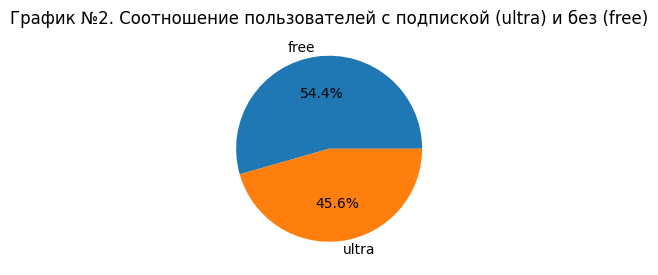

In [22]:
users['subscription_type'].value_counts().plot(
    kind = 'pie',
    figsize = (3,4),
    autopct='%1.1f%%',
    title = 'График №2. Соотношение пользователей с подпиской (ultra) и без (free)',
    ylabel=''
);

Чаще встречаются пользователи без подписки, их 54.4% чел. С подпиской - 45.6%.

#### 3.3 Посмотрим на возраст пользователей

In [23]:
users['age'].sort_values().unique()

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
       29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 43], dtype=int64)

In [24]:
def hist_column(df, column_name, **kwargs):
    """
    Определим функцию, которая будет для столбца строить гистограмму
    В качестве первого аргумента принимает датафрейм, 
    в качестве второго название столбца, 
    через kwargs можно передать др.доп параметры для гистограммы.
    """
    df[column_name].hist(**kwargs)
    plt.ylabel('количество');
    plt.show()

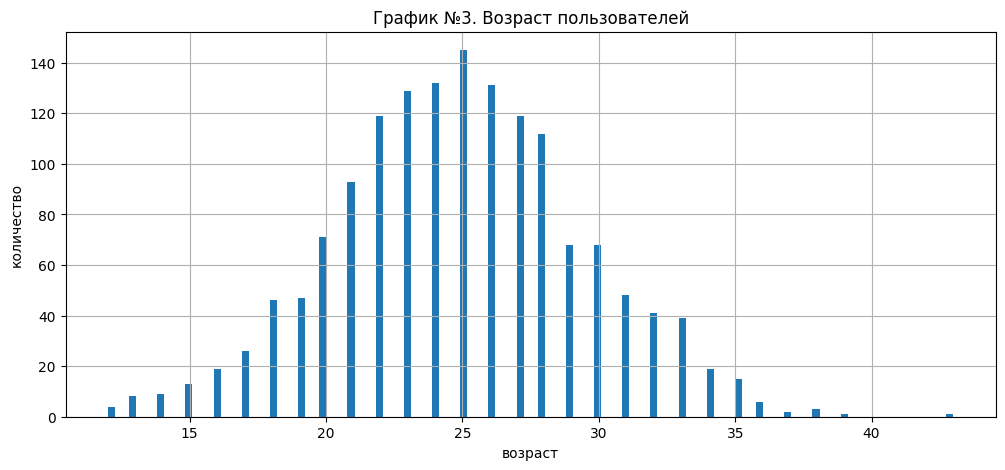

In [25]:
plt.title('График №3. Возраст пользователей')
plt.xlabel('возраст');
hist_column(
    users,
    'age',
    figsize = (12,5), 
    bins = 120)

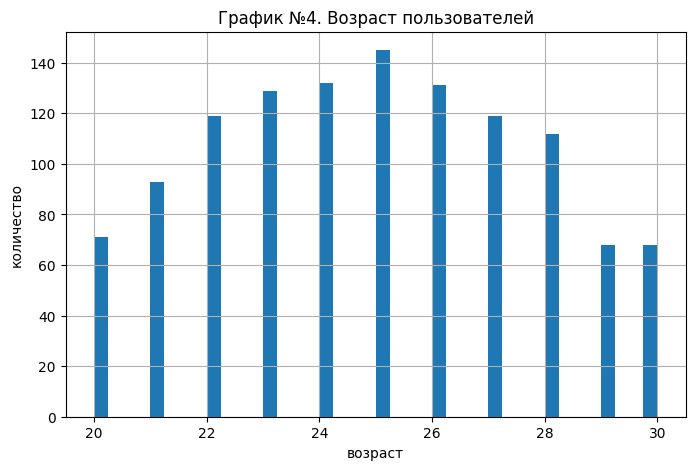

In [26]:
plt.title('График №4. Возраст пользователей')
plt.xlabel('возраст');
hist_column(
    users,
    'age',
    figsize = (8,5), 
    bins =40 , 
    range = (20,30)
)

Также интересно посмотреть на возраст людей с подпиской:

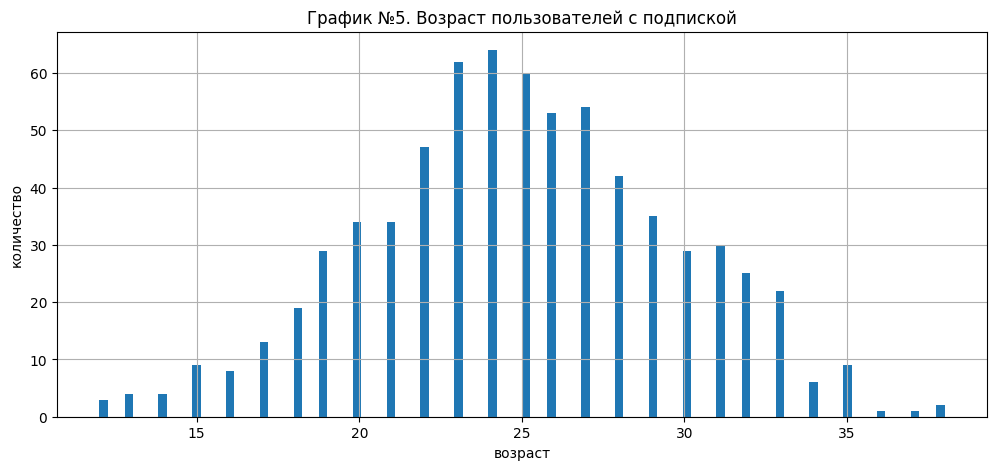

In [27]:
plt.title('График №5. Возраст пользователей с подпиской')
plt.xlabel('возраст');
hist_column(
    users.query('subscription_type == "ultra"'),
    'age',
    figsize = (12,5), 
    bins = 100
)

In [28]:
users.query(
    'subscription_type == "ultra"'
)['age'].value_counts()

24    64
23    62
25    60
27    54
26    53
22    47
28    42
29    35
20    34
21    34
31    30
19    29
30    29
32    25
33    22
18    19
17    13
15     9
35     9
16     8
34     6
14     4
13     4
12     3
38     2
36     1
37     1
Name: age, dtype: int64

График размаха и отображение статистических показателей по возрасту представлены ниже:

In [29]:
def describe_column(df, column_name, title='', **kwargs):
    """
    Определим функцию для вывода диаграммы размаха столбца и характеристики
    В качестве первого аргумента принимает датафрейм, 
    в качестве второго название столбца, 
    через kwargs можно передать доп.параметры для отображения диаграммы.
    """
    df.boxplot(column=[column_name], figsize=(4, 4), grid=True, **kwargs)
    plt.title(title)  # Добавляем название графика
    plt.show()
    
    column_describe = df[column_name].describe()
    IQR = column_describe['75%'] - column_describe['25%']
    print ('Стат.показатели:','\n', column_describe,'\n\n',
           'Межквартильный размах = ', IQR,'\n\n',
           'Пределы нормальных значений (или усы) = ({0},{1})'.
           format((column_describe['25%']-1.5*IQR),(column_describe['75%']+1.5*IQR)),'\n\n')

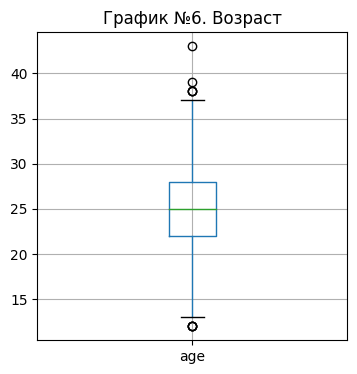

Стат.показатели: 
 count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64 

 Межквартильный размах =  6.0 

 Пределы нормальных значений (или усы) = (13.0,37.0) 




In [30]:
describe_column(
    users, 
    'age', 
    title='График №6. Возраст'
)

Сервисом пользуются люди разных возрастов от 12 до 43 лет. Больше всего пользователей в возрасте от 22 до 28 лет, медианное значение - 25 лет. 

Среди пользователей с подпиской также чаще встречаются люди 22-28 лет.


#### 3.4 Посмотрим расстояние, которое пользователь преодолевает за одну поездку

In [31]:
#Запишем ср. расстояние одной поездки для каждого пользователя
average_distanse = rides.pivot_table(
    index = 'user_id', 
    values = 'distance'
)
print ('Ср. расстояние, кот. пользователи преодолевают за 1 поездку = {0} м'.format(
        round(average_distanse.mean()[0],1))
      )

Ср. расстояние, кот. пользователи преодолевают за 1 поездку = 3077.3 м


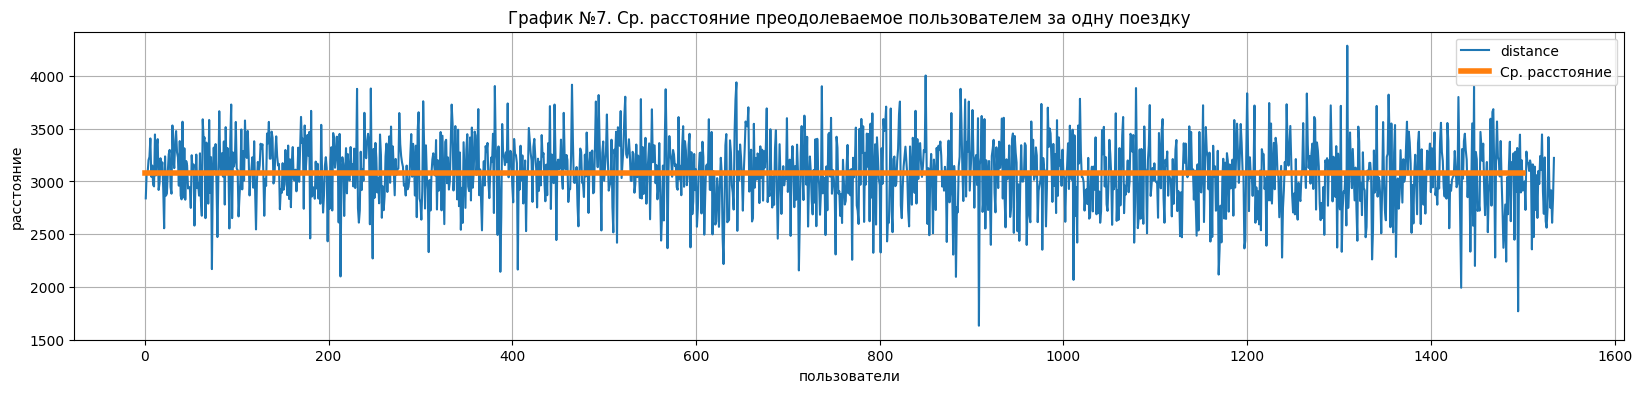

In [32]:
average_distanse.plot(
    grid=True, 
    figsize = (20,4),
    ylabel = 'расстояние',
    xlabel = 'пользователи',
    title = 'График №7. Ср. расстояние преодолеваемое пользователем за одну поездку'
)

plt.plot(
    [0,1500],
    [round(average_distanse.mean()[0],1),round(average_distanse.mean()[0],1)],
    linewidth=4,
    label = 'Ср. расстояние'
    )

plt.legend();

На графике 7 видим среднее расстояние, которое проходит каждый пользователь за одну поездку. 

График размаха и отображение статистических показателей по среднему расстоянию пользователей представлены ниже:

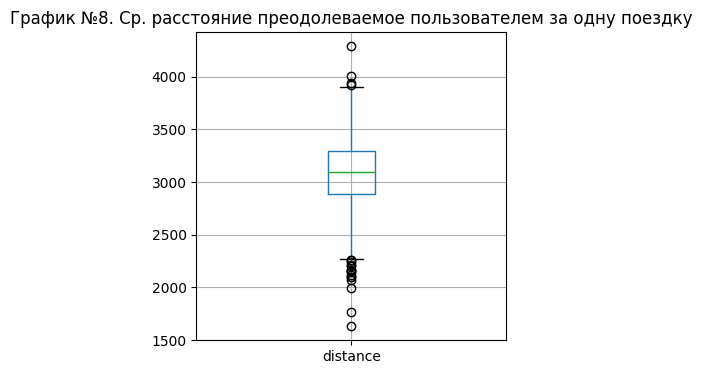

Стат.показатели: 
 count    1534.000000
mean     3077.296650
std       327.624403
min      1630.788427
25%      2882.505704
50%      3090.864050
75%      3293.325678
max      4287.519387
Name: distance, dtype: float64 

 Межквартильный размах =  410.81997445146453 

 Пределы нормальных значений (или усы) = (2266.275742358461,3909.555640164319) 




In [33]:
describe_column(
    average_distanse, 
    'distance', 
    title = 'График №8. Ср. расстояние преодолеваемое \
пользователем за одну поездку')

В среднем пользователи за одну поездку преодолевают расстояние 3077.3 м. Стандартное отклонение от среднего 328м.

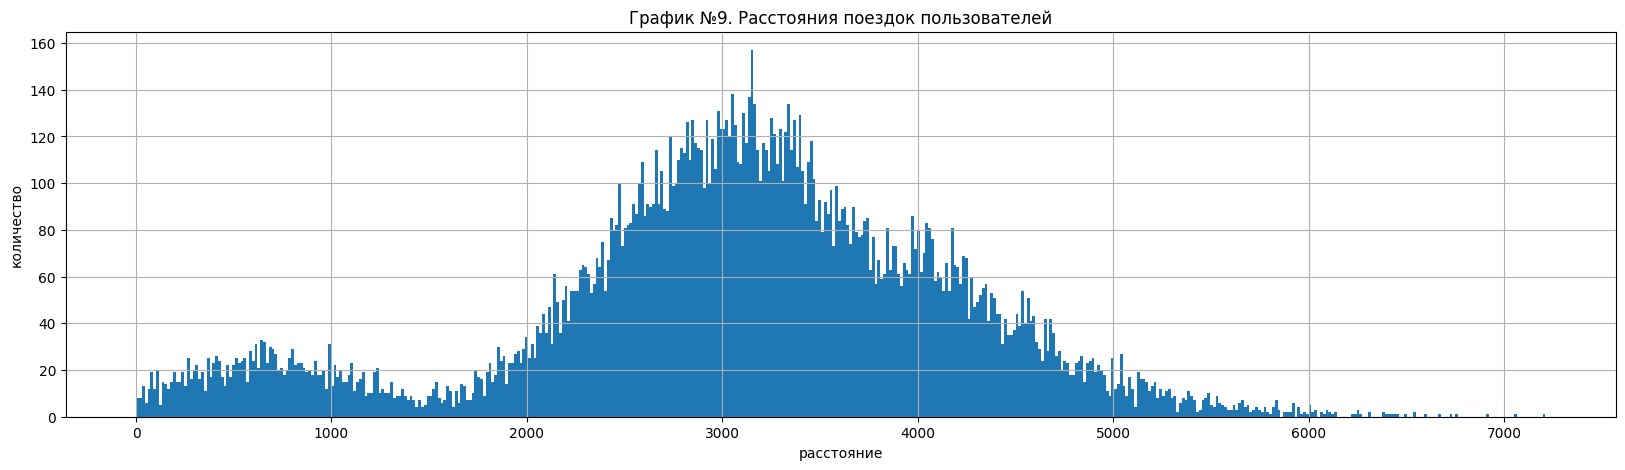

In [34]:
plt.title('График №9. Расстояния поездок пользователей')
plt.xlabel ('расстояние')
hist_column(
    rides,
    'distance',
    figsize = (20,5), 
    bins = 500
)

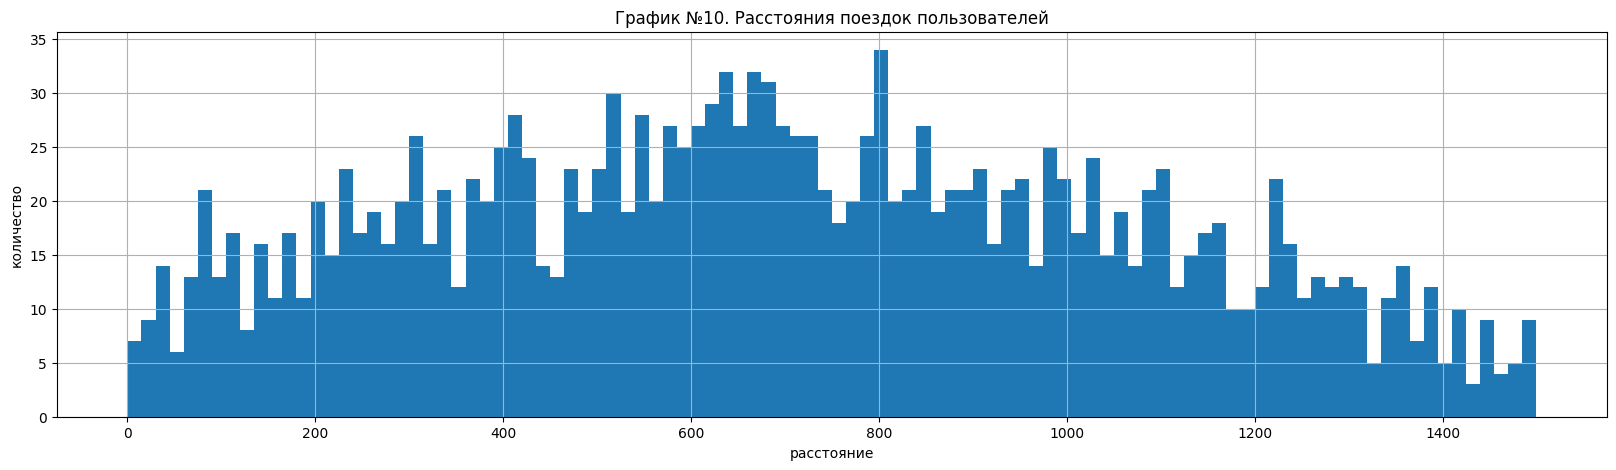

In [35]:
plt.title('График №10. Расстояния поездок пользователей')
plt.xlabel ('расстояние')
hist_column(
    rides,
    'distance',
    figsize = (20,5), 
    bins = 100,
    range = (0,1500)
)

График 9 и 10 показывают частоту встречаемости расстояний поездок пользователей. 

Видим некоторую бимодальность распределения:

- чаще других встречаются длинные поездки около 2900-3200м

- чаще других встречаются короткие поездки около 600-800 м. 

Возможно встречаемые часто короткие поездки совершают пользователи, которым не понравился сервис? Проверим такое предположение, посмотрим есть ли у пользователей, проехавших такое расстояние еще поездки:

In [36]:
#Находим с помощью сводной кол-во поездок каждого пользователя
count_rides_data = rides.pivot_table (
    index = 'user_id', 
    values = 'distance',
    aggfunc = 'count'
)
count_rides_data.columns = ['count_rides']

In [37]:
#Объединим таблицы
rides = rides.merge(count_rides_data,on='user_id',how='outer')

In [38]:
#Проверяем
rides.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   user_id      18068 non-null  int64         
 1   distance     18068 non-null  float64       
 2   duration     18068 non-null  float64       
 3   date         18068 non-null  datetime64[ns]
 4   month        18068 non-null  int64         
 5   year         18068 non-null  int64         
 6   count_rides  18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 1.1 MB


Смотрим есть ли поездки у пользователей в нужном диапазоне:

In [39]:
print (display(rides.query('(distance < 650) & (distance > 550)')
               .sort_values(by='count_rides')))

,user_id,distance,duration,date,month,year,count_rides
1397,151,620.546434,11.489311,2021-12-01,12,2021,5
1843,199,606.203843,4.347120,2021-03-27,3,2021,5
5264,565,613.123075,5.452492,2021-09-10,9,2021,5
7575,777,554.591140,12.331019,2021-10-14,10,2021,5
3176,344,642.472335,13.212362,2021-02-05,2,2021,6
...,...,...,...,...,...,...,...
10819,1016,560.880788,5.602517,2021-02-05,2,2021,20
9305,909,607.256451,4.735018,2021-04-19,4,2021,21
17716,1510,649.157738,13.163859,2021-11-10,11,2021,21
8266,831,588.953276,5.718246,2021-02-15,2,2021,22


None


У таких пользователей больше пяти поездок, так что наше предположение неверно. Если бы пользователям не понравился сервис, у них не было бы нескольких поездок. Природа всплеска пока остается неизвестной, и требует дополнительного анализа.

#### 3.5 Посмотрим продолжительность поездок

In [40]:
#Запишем ср. длительность одной поездки для каждого пользователя
average_duration = rides.pivot_table(
    index = 'user_id', 
    values = 'duration'
)
print ('Ср. длительность поездок пользователей = {0} мин'.format(
        round(average_duration.mean()[0],1))
      )

Ср. длительность поездок пользователей = 17.9 мин


График размаха и отображение статистических показателей по средней длительности поездок пользователей представлены ниже:

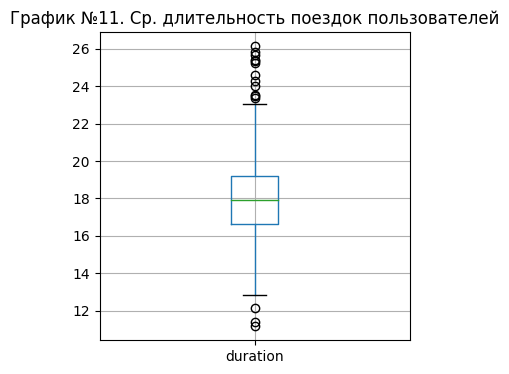

Стат.показатели: 
 count    1534.000000
mean       17.926440
std         1.971150
min        11.163431
25%        16.613880
50%        17.903937
75%        19.198581
max        26.136000
Name: duration, dtype: float64 

 Межквартильный размах =  2.584701346222559 

 Пределы нормальных значений (или усы) = (12.736828106052364,23.0756334909426) 




In [41]:
describe_column(
    average_duration, 
    'duration', 
    title = 'График №11. Ср. длительность поездок пользователей'
)

В среднем длительность одной поездки пользователя составляет 17.9 мин. Стандартное отклонение от среднего 2 мин.

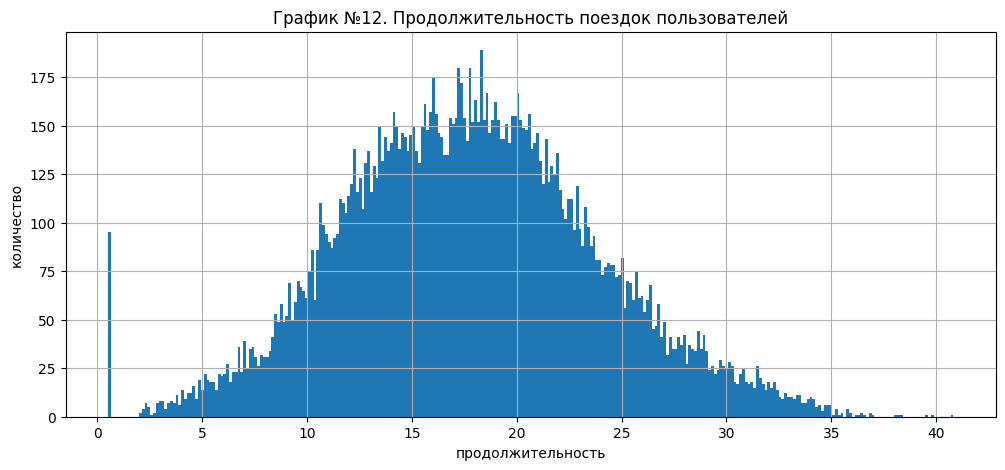

In [42]:
plt.xlabel('продолжительность')
plt.title('График №12. Продолжительность поездок пользователей')
hist_column(rides,'duration',figsize = (12,5), bins = 300)

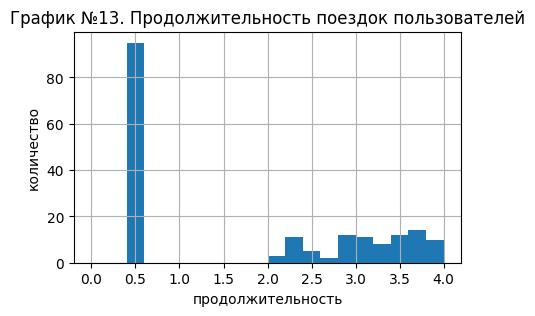

In [43]:
plt.title('График №13. Продолжительность поездок пользователей')
plt.xlabel('продолжительность')
hist_column(
    rides,
    'duration',
    figsize = (5,3), 
    bins = 20,
    range = (0,4)
)

Графики 12 и 13 показывают частоту встречаемости длительности поездок пользователей. Видим небольшой всплеск поездок длительностью меньше 1 минуты, найдем количество таких поездок и посмотрим их описание:

In [44]:
rides_1min = rides.query('duration < 1')

display(rides_1min)

print ('кол-во поездок < 1 мин = ', rides_1min.shape[0])

,user_id,distance,duration,date,month,year,count_rides
6531,701,4196.445201,0.5,2021-08-31,8,2021,20
6570,704,4830.824371,0.5,2021-10-14,10,2021,16
6680,712,4684.004397,0.5,2021-03-04,3,2021,14
6695,713,5215.642710,0.5,2021-02-25,2,2021,14
6768,718,5197.436649,0.5,2021-02-11,2,2021,11
...,...,...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1,2021,17
17242,1477,6724.932981,0.5,2021-01-12,1,2021,16
17314,1483,4445.481070,0.5,2021-03-06,3,2021,9
17505,1496,5722.551787,0.5,2021-02-14,2,2021,10


кол-во поездок < 1 мин =  95


In [45]:
rides_1min['duration'].unique()

array([0.5])

Таких поездок - 95 (напоминаем, что всего поездок 18068). У всех них длительность равно 0.5 мин, и видим что похоже у всех них очень большое расстояние, в остальном даты различны, месяца различны, количество поездок пользователей различно.

Проверим диапазон встречающихся расстояний в этих поездках:

In [46]:
rides_1min['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

Действительно, все эти поездки на расстояние больше 4030м, что похоже на какую-то ошибку в приложении или датчике самокатов. 

Проверим встречаются ли поездки больше 4030 м с корректной длительностью (> 1мин):

In [47]:
rides.query('duration > 1 and distance >4030 ')

,user_id,distance,duration,date,month,year,count_rides
0,1,4409.919140,25.599769,2021-01-01,1,2021,12
10,1,4031.020195,17.674448,2021-12-14,12,2021,12
32,3,5335.212090,25.848038,2021-07-14,7,2021,12
41,4,4208.708402,22.979239,2021-07-17,7,2021,14
42,4,4649.488243,35.896929,2021-08-14,8,2021,14
...,...,...,...,...,...,...,...
18034,1532,4602.642357,32.013212,2021-08-21,8,2021,13
18040,1532,4551.698449,31.007839,2021-12-21,12,2021,13
18053,1533,4581.943632,21.163887,2021-08-27,8,2021,13
18055,1534,4678.415899,15.228198,2021-01-20,1,2021,13


Таких поездок также полно. Больше идей насчет природы бага о поездках меньше минуты нет, но обязательно укажем это в отчете, чтобы можно было завести отдельную задачу.

#### 3.6 Объединим данные о пользователях, поездках и подписках в один датафрейм


In [48]:
general_data = users.merge(rides, on='user_id', how='outer')

In [49]:
general_data = general_data.merge(
    subscriptions,
    on = 'subscription_type',
    how='outer'
)

In [50]:
#Проверяем
general_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   year               18068 non-null  int64         
 10  count_rides        18068 non-null  int64         
 11  minute_price       18068 non-null  int64         
 12  start_ride_price   18068 non-null  int64         
 13  subscription_fee   18068 non-null  int64         
dtypes: dat

#### 3.7 Создадим ещё два датафрейма из датафрейма `general_data` c данными о пользователях с подпиской и без

In [51]:
general_data_with_ultra = general_data.query('subscription_type == "ultra"')

#Проверяем
print(general_data_with_ultra['subscription_type'].value_counts(),'\n')
print(display(general_data_with_ultra.head()))

ultra    6500
Name: subscription_type, dtype: int64 



,user_id,name,age,city,subscription_type,distance,duration,date,month,year,count_rides,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,2021,12,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,2021,12,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,2021,12,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,2021,12,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,2021,12,6,0,199


None


In [52]:
general_data_with_free = general_data.query('subscription_type == "free"')

#Проверяем
print(general_data_with_free['subscription_type'].value_counts(),'\n')
print(display(general_data_with_free.head()))

free    11568
Name: subscription_type, dtype: int64 



,user_id,name,age,city,subscription_type,distance,duration,date,month,year,count_rides,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,2021,18,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,2021,18,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,2021,18,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,2021,18,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,2021,18,8,50,0


None


#### 3.8 Визуализируем информацию о расстоянии и времени поездок для пользователей обеих категорий:

In [53]:
#Запишем ср. длительность одной поездки
# для каждого пользователя с подпиской
average_duration_ultra = general_data_with_ultra.pivot_table(
    index = 'user_id', 
    values = 'duration'
)

print ('Ср. длительность поездок пользователей\
с подпиской = {0} мин'.format(round(average_duration_ultra.mean()[0],1)))


#Запишем ср. длительность одной поездки
# для каждого пользователя без подписки
average_duration_free = general_data_with_free.pivot_table(
    index = 'user_id', 
    values = 'duration'
)

print ('Ср. длительность поездок пользователей\
без подписки = {0} мин'.format(round(average_duration_free.mean()[0],1)))

Ср. длительность поездок пользователейс подпиской = 18.6 мин
Ср. длительность поездок пользователейбез подписки = 17.4 мин


График размаха и отображение статистических показателей по средней длительности поездок пользователей с подпиской и без представлены ниже:

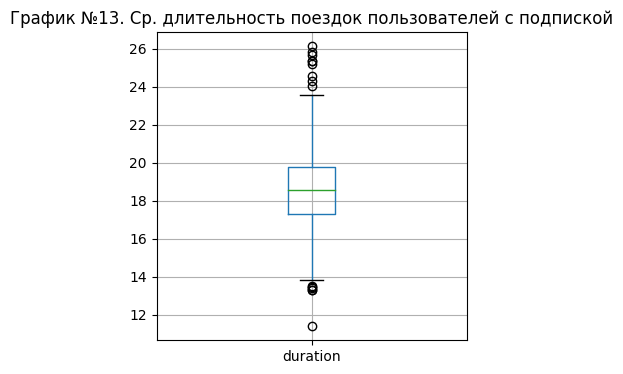

Стат.показатели: 
 count    699.000000
mean      18.574380
std        2.015094
min       11.385922
25%       17.278630
50%       18.585189
75%       19.789236
max       26.136000
Name: duration, dtype: float64 

 Межквартильный размах =  2.510605810847828 

 Пределы нормальных значений (или усы) = (13.512721380447598,23.55514462383891) 




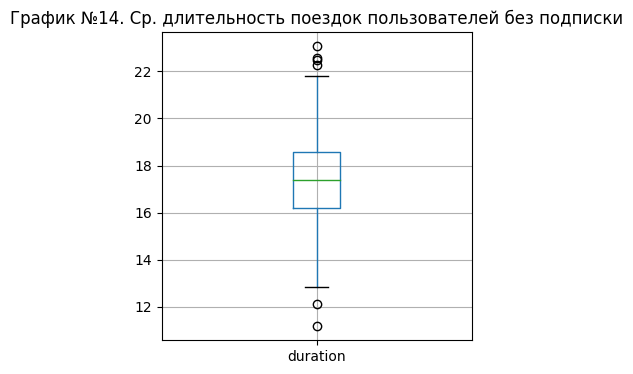

Стат.показатели: 
 count    835.000000
mean      17.384033
std        1.759845
min       11.163431
25%       16.209124
50%       17.402644
75%       18.568622
max       23.069943
Name: duration, dtype: float64 

 Межквартильный размах =  2.3594979566635104 

 Пределы нормальных значений (или усы) = (12.669877102558711,22.107868929212753) 




In [54]:
describe_column(
    average_duration_ultra, 
    'duration', 
    title = 'График №13. Ср. длительность поездок пользователей с подпиской'
)

describe_column(
    average_duration_free, 
    'duration', 
    title = 'График №14. Ср. длительность поездок пользователей без подписки'
)


Средняя продолжительность поездок для пользователей с подпиской - 18.6 мин, стандартное отклонение 2 мин.

Средняя продолжительность поездок для пользователей  без подписки - 17.4 мин, стандартное отклонение 1.8 мин.

Построим график, отображающий частоту встречаемости длительности поездок пользователей с подпиской и без:

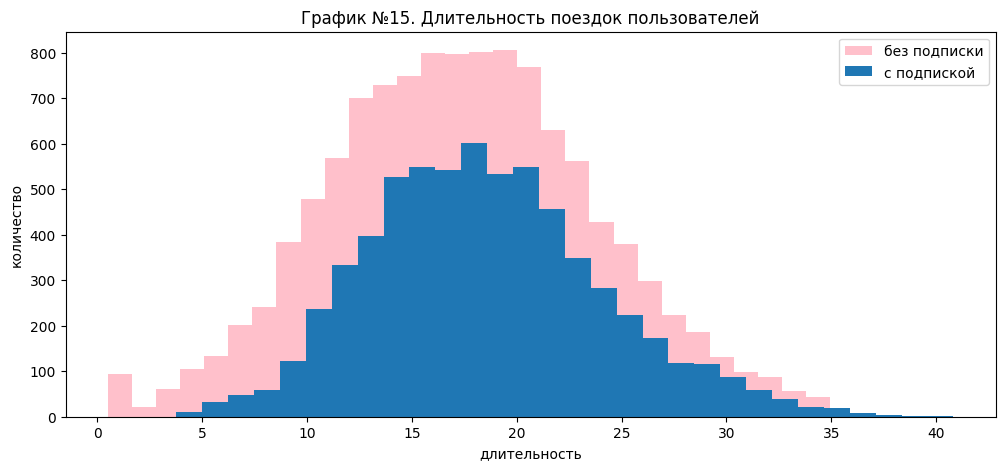

In [55]:
plt.figure(figsize = (12,5))
  
general_data_with_free['duration'].plot.hist( 
    label='без подписки', 
    color='pink', 
    bins = 30)

general_data_with_ultra['duration'].plot.hist( 
    label='с подпиской',
    bins = 30)
  
plt.title('График №15. Длительность поездок пользователей')
plt.xlabel('длительность')
plt.ylabel('количество')
plt.legend();

Некоторый пик поездок меньше 1 минуты, который мы наблюдали выше, проявляется только для пользователей без подписки. 

Среди пользователей с подпиской встречаются более долгие поездки (более 35 минут) чем у пользователей без подписки.

У пользователей без подписки больший разброс от среднего значения.

In [56]:
#Запишем ср. расстояние одной поездки
#для каждого пользователя с подпиской
average_distanse_ultra =  general_data_with_ultra.pivot_table(
    index = 'user_id', 
    values = 'distance'
)

print ('Ср. расстояние, кот. пользователи с подпиской \
преодолевают за 1 поездку = {0} м'.format(
        round(average_distanse_ultra.mean()[0],1))
      )

#Запишем ср. расстояние одной поездки
#для каждого пользователя без подписки
average_distanse_free =  general_data_with_free.pivot_table(
    index = 'user_id', 
    values = 'distance'
)

print ('Ср. расстояние, кот. пользователи без подписки\
преодолевают за 1 поездку = {0} м'.format(
        round(average_distanse_free.mean()[0],1))
      )

Ср. расстояние, кот. пользователи с подпиской преодолевают за 1 поездку = 3113.5 м
Ср. расстояние, кот. пользователи без подпискипреодолевают за 1 поездку = 3047.0 м


График размаха и отображение статистических показателей по среднему расстоянию пользователей представлены ниже:

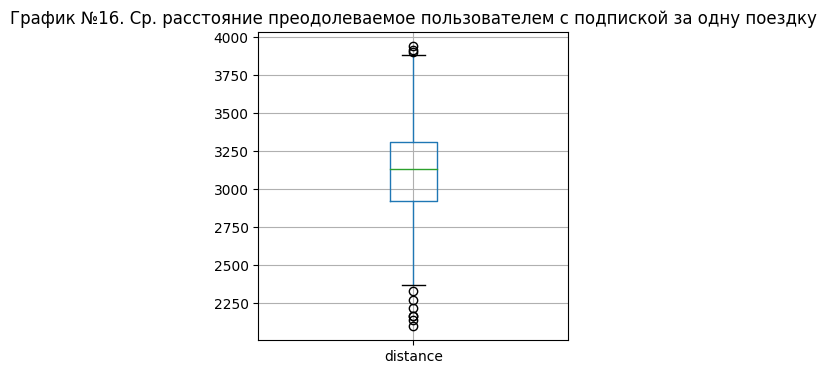

Стат.показатели: 
 count     699.000000
mean     3113.459926
std       299.706136
min      2098.297845
25%      2925.005435
50%      3134.349186
75%      3312.191643
max      3939.773328
Name: distance, dtype: float64 

 Межквартильный размах =  387.1862080654869 

 Пределы нормальных значений (или усы) = (2344.2261225826987,3892.9709548446463) 




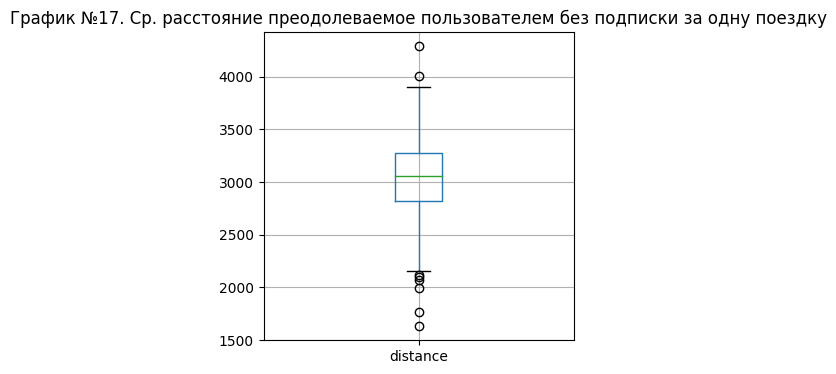

Стат.показатели: 
 count     835.000000
mean     3047.023441
std       346.570021
min      1630.788427
25%      2820.516763
50%      3057.940909
75%      3276.990199
max      4287.519387
Name: distance, dtype: float64 

 Межквартильный размах =  456.47343650085713 

 Пределы нормальных значений (или усы) = (2135.8066081621155,3961.700354165544) 




In [57]:
describe_column(
    average_distanse_ultra, 
    'distance', 
    title = 'График №16. Ср. расстояние преодолеваемое \
пользователем с подпиской за одну поездку'
)

describe_column(
    average_distanse_free, 
    'distance', 
    title = 'График №17. Ср. расстояние преодолеваемое \
пользователем без подписки за одну поездку'
)

Ср. расстояние для пользователей с подпиской равно 3113м, стандартное отклонение - 299м.

Ср. расстояние для пользователей без подписки равно 3047м, стандартное отклонение - 347м.

Построим график, отображающий частоту встречаемости дальности поездок пользователей с подпиской и без:

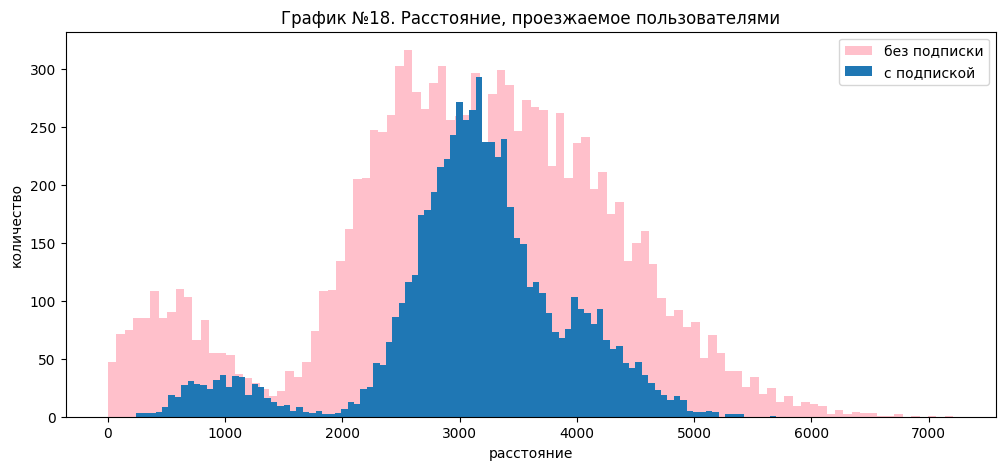

In [58]:
plt.figure(figsize = (12,5))
  
general_data_with_free['distance'].plot.hist( 
    label='без подписки', 
    color='pink', 
    bins = 100)

general_data_with_ultra['distance'].plot.hist( 
    label='с подпиской',
    bins = 100)
  
plt.title('График №18. Расстояние, проезжаемое пользователями')
plt.xlabel('расстояние')
plt.ylabel('количество')
plt.legend();

Для пользователей с подпиской есть несколько пиков проезжаемых расстояний: около 1000м, около 3100м и около 4100м.

Для пользователей без подписки наблюдается больший разброс от среднего значения, и бимодальность - два пика проезжаемых расстояний: около 600-800м, и около 3000м.

#### 3.9 Подсчет выручки: Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4. Найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц.

In [59]:
#Округляем длительность поездок до целых минут
general_data['duration'] = np.ceil(general_data['duration'])

#Округляем до второго знака после запятой расстояние
general_data['distance'] = round(general_data['distance'],2)

#Проверяем:
general_data.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,year,count_rides,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.92,26.0,2021-01-01,1,2021,12,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.59,16.0,2021-01-18,1,2021,12,6,0,199
2,1,Кира,22,Тюмень,ultra,754.16,7.0,2021-04-20,4,2021,12,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.78,19.0,2021-08-11,8,2021,12,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.69,27.0,2021-08-28,8,2021,12,6,0,199


In [60]:
#Создаем агрегированный датафрейм
agg_data = general_data.groupby(['month','user_id']).agg(
    {
        'distance':['count','sum'],
        'duration':['sum'],
        'subscription_type':['first'],
        'minute_price':['first'],
        'start_ride_price':['first'], 
        'subscription_fee':['first']
    }
)

#Переименовываем столбцы
agg_data.columns = [
    'count_rides',
    'sum_distance',
    'sum_duration',
    'subscription_type',
    'minute_price',
    'start_ride_price', 
    'subscription_fee'  
]

In [61]:
#Проверяем
agg_data.head()

count_rides  sum_distance  sum_duration subscription_type  \
month user_id                                                              
1     1                  2       7027.51          42.0             ultra   
      3                  1       3061.78          13.0             ultra   
      5                  1       3914.65          13.0             ultra   
      7                  2       6478.08          28.0             ultra   
      12                 1       3577.15          33.0             ultra   

               minute_price  start_ride_price  subscription_fee  
month user_id                                                    
1     1                   6                 0               199  
      3                   6                 0               199  
      5                   6                 0               199  
      7                   6                 0               199  
      12                  6                 0               199

In [62]:
#Проверяем на пропуски
agg_data.isna().sum()

count_rides          0
sum_distance         0
sum_duration         0
subscription_type    0
minute_price         0
start_ride_price     0
subscription_fee     0
dtype: int64

#### 3.10 В этот же датафрейм добавим столбец с помесячной выручкой, которую принёс каждый пользователь 

In [63]:
def func_monthly_revenue(row):
    """
    Функция для расчета помесячной выручки
    в качетсве аргумента принимает строку датафрейма
    """
    result = (row['start_ride_price']*row['count_rides']) + \
    (row['minute_price']*row['sum_duration']) + row['subscription_fee']
    return  result

In [64]:
agg_data['monthly_revenue'] = agg_data.apply(func_monthly_revenue, axis=1)
                  
# Проверяем
print (display(agg_data.info(), agg_data.tail()))

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (12, 1534)
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   count_rides        11331 non-null  int64  
 1   sum_distance       11331 non-null  float64
 2   sum_duration       11331 non-null  float64
 3   subscription_type  11331 non-null  object 
 4   minute_price       11331 non-null  int64  
 5   start_ride_price   11331 non-null  int64  
 6   subscription_fee   11331 non-null  int64  
 7   monthly_revenue    11331 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 753.6+ KB


None

count_rides  sum_distance  sum_duration subscription_type  \
month user_id                                                              
12    1525               1       4597.85          34.0              free   
      1526               1       3644.12          23.0              free   
      1528               1       3998.57          11.0              free   
      1532               2       6111.89          42.0              free   
      1534               1       2371.71          16.0              free   

               minute_price  start_ride_price  subscription_fee  \
month user_id                                                     
12    1525                8                50                 0   
      1526                8                50                 0   
      1528                8                50                 0   
      1532                8                50                 0   
      1534                8                50                 0   

               monthly_revenue  
month user_id                   
12    1525               322.0  
      1526               234.0  
      1528               138.0  
      1532               436.0  
      1534               178.0

None


### Шаг 4. Проверка гипотез

#### 4.1 Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим гипотезу.

Нулевая гипотеза: средние значения потраченного времени в обеих группах равны

Альтернативная гипотеза: среднее значение потраченного времени у пользователей с подпиской больше, чем среднее потраченное время у пользователей без подписки.

In [65]:
#Уровень стат.значимости
alpha = 0.05

#проведем стат. тест
results = st.ttest_ind(
    general_data_with_ultra['duration'], 
    general_data_with_free['duration'],
    alternative='greater'
)

#получившееся p-значение
print('p-value:', results.pvalue)

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу','\n')
else:
    print('Нет оснований отвергнуть нулевую гипотезу','\n')
    
#Средние значения 
print ('Ср. значение времени поездки для пользователей с подпиской = ', 
       round(general_data_with_ultra['duration'].mean(),2),'\n')

print ('Ср. значение времени поездки для пользователей без подписки = ', 
       round(general_data_with_free['duration'].mean(),2),'\n')

p-value: 1.2804098316645618e-34
Отвергаем нулевую гипотезу 

Ср. значение времени поездки для пользователей с подпиской =  18.54 

Ср. значение времени поездки для пользователей без подписки =  17.39 



Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу (т.е. вероятность получить наблюдаемые данные, подтверждающие нулевую гипотезу низки).

Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки.

#### 4.2 Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Проверим, можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 4
Нулевая гипотеза: среднее расстояние поездки равно 3130м

Альтернативная гипотеза: среднее расстояние поездки больше 3130м

In [66]:
set_distance = 3130

# уровень статистической значимости
alpha = 0.05 

#проведем стат. тест
results = st.ttest_1samp(
    general_data_with_ultra['distance'], 
    set_distance,
    alternative='greater'
)

print('p-value:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу','\n')
else:
    print('Не отвергаем нулевую гипотезу','\n')
    
print ('Ср. значение проезжаемого расстояния \
для пользователей с подпиской = ', 
       round(general_data_with_ultra['distance'].mean(),2))

p-value: 0.9195368847849785
Не отвергаем нулевую гипотезу 

Ср. значение проезжаемого расстояния для пользователей с подпиской =  3115.45


Первый и третий квантили = 2925 м и 3312.2 м.

Вероятность получить в нашей выборке наблюдаемое значение (3130м) или меньшее составляет 92 процента. 

Соответственно, по результатам стат.теста можно считать, что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130м. И в большинстве случаев проезжаемое расстояние будет оптимальным с точки зрения износа самоката.  


#### 4.3. Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки

Нулевая гипотеза: помесячная выручка в обеих группах равна

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской больше, чем помесячная выручка от пользователей без подписки.

In [67]:
monthly_revenue_ultra = agg_data.query(
    'subscription_type == "ultra"'
)['monthly_revenue']

monthly_revenue_free = agg_data.query(
    'subscription_type == "free"'
)['monthly_revenue']

#Уровень стат.значимости
alpha = 0.05

#проведем стат. тест
results = st.ttest_ind(
    monthly_revenue_ultra, 
    monthly_revenue_free,
    alternative='greater'
)

#получившееся p-значение
print('p-value:', results.pvalue)

# проверяем p-value
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу','\n')
else:
    print('Нет оснований отвергнуть нулевую гипотезу','\n')
    
print ('Ср. значение помесячной выручки \
для пользователей с подпиской = ', 
       round(monthly_revenue_ultra.mean(),2))

print ('Ср. значение помесячной выручки \
для пользователей без подписки = ', 
       round(monthly_revenue_free.mean(),2))

p-value: 1.8850394384715216e-31
Отвергаем нулевую гипотезу 

Ср. значение помесячной выручки для пользователей с подпиской =  362.79
Ср. значение помесячной выручки для пользователей без подписки =  328.64


Полученное значение p-value меньше заданного уровня значимости, поэтому можно отвергнуть нулевую гипотезу. Есть основания говорить, что пользователи с подпиской приносят большую помесячную выручку, чем бользователи без подписки.

### Шаг 5. Найдем минимальное количество промокодов для акции

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. 
Эта акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. Выясните, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберите параметры распределения, описывающего эту ситуацию, постройте график распределения и сформулируйте ответ на вопрос о количестве промокодов.

In [68]:
from math import sqrt
import matplotlib.pyplot as plt
from scipy.stats import binom, norm

#Параметры биномиального распределения
n = 1000
p = 0.1

#Начальное значение вероятности
prob = 0.3

#Порог
alpha = 0.05

while (prob>=alpha):
    n+=1
    
    #Расчитаем параметры нормального распр.
    mu = n*p
    sigma = sqrt(n*p*(1-p))
    
    #Задаем норм. распределение
    distr = st.norm(mu,sigma)
    
    prob = distr.cdf(100)
 
print('Вероятность получить продление менее чем от 100 чел = ', 
      round(prob,2),'\n'
      'Нужное для этого кол-во промокодов =', n)

Вероятность получить продление менее чем от 100 чел =  0.05 
Нужное для этого кол-во промокодов = 1169


Запишем вспомогательную функцию, кот. понадобится для визуализации нормального распределения:

In [69]:
def linspace(start, stop, num):
    """
    зададим функцию, которая выдаёт <num> чисел,
    равномерно распределённых от <start> до <stop>
    """
    step = (stop - start) / (num - 1)
    result = []
    for i in range(num):
        result.append(start + step * i)
    return result

Границы промежутка, в котором будем строить аппроксимацию n*p ± 4 ст.отклонения бином.распределения (там, где вероятности значений почти не равны нулю)

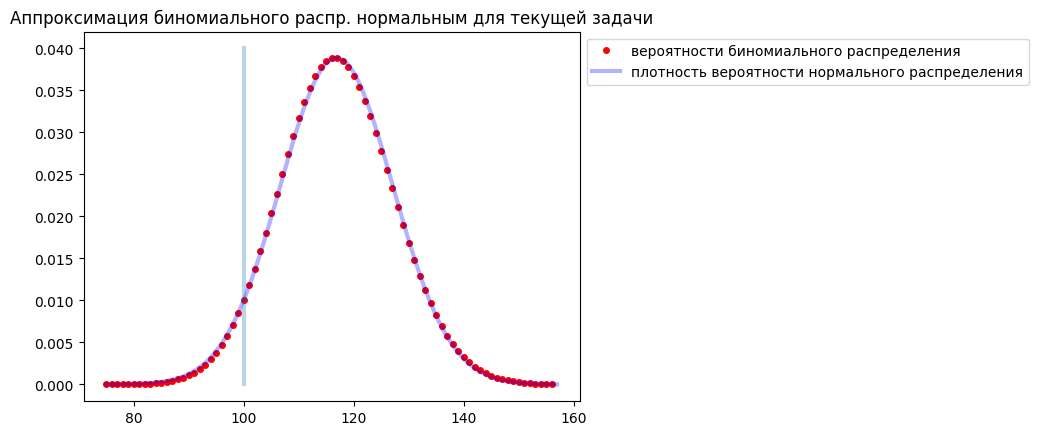

In [70]:
left = int(n * p - 4 * sqrt(n * p * (1 - p)))
right = int(n * p + 4 * sqrt(n * p * (1 - p)))
 
#зададим набор значений бином. величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
x = list(range(max(0, left), right))

# рисуем график биномиального распределения
ax = plt.subplot()
ax.plot(
    x, binom.pmf(x, n, p), 
    'ro', ms=4,
    label='вероятности биномиального распределения')

# рисуем график нормального распределения:
# получим список из 100 чисел от left до right
x = linspace(left, right, 100)
ax.plot(
    x,  norm.pdf(x, mu, sigma), 
    'b-', lw=3, alpha=0.3, 
    label='плотность вероятности нормального распределения')

ax.plot(
    [100,100],
    [0,0.04],
    linewidth=3,
    alpha=0.3
)

# настраиваем оптимальное расположение легенды и выводим график
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_title(
    'Аппроксимация биномиального распр. нормальным для текущей задачи'
)
plt.show()


Чтобы вероятность не выполнить план (получить меньше 100 продлений) была примерно 5 %, необходимо разослать минимум 1169 промокодов.

<a id='section_8'></a>
### Шаг 6. Общий вывод

#### Цели исследования:

GoFast - сервис аренды самокатов. Есть данные о некоторых пользователях из нескольких городов, а также об их поездках. 

Необходимо проанализировать данные и проверить некоторые предложенные гипотезы, которые могут помочь бизнесу вырасти.

Гипотезы:

 1) Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

 2) Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

 3) Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

***
#### Полученные данные были изучены и прошли следующую обработку:

В полученных данных содержится информация о 18068 поездках от 1565 пользователей. Все поездки совершены за 2021год.

* В датафрейме пользователей было обнаружено и удалено 31 строк-дубликатов.

* Пропущенных значений в датафреймах не было обнаружено.

* В датафрейме поездок был изменен тип столбца `date` на тип datetime.

* В датафрейм поездок был добавлен столбец `month`, содержащий месяц поездки и столбец `count_rides`, содержащий количество поездок.

* Данные о пользователях, поездках и подписках были объединены в один датафрейм `general_data`.

* Были созданы еще два датафрейма c данными о пользователях с подпиской `general_data_with_ultra` и без `general_data_with_free`.

* Данные столбцов `duration` были округлены до целого, данные столбца `distance` были округлены до второго знака после запятой.

* Найдено и добавлено в новый датафрейм `agg_data` суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц, а также выручка по пользователям по месяцам.

***

#### Анализ и исследования:

**Опиcание и визуализация информации о пользователях и поездках:**

* Больше всего пользователей в Пятигорске - 219 и меньше всего в Москве - 168.

* Чаще встречаются пользователи без подписки, их 54.4%. С подпиской - 45.6%.

* Сервисом пользуются люди разных возрастов от 12 до 43 лет. Больше всего пользователей в возрасте от 22 до 28 лет, медианное значение - 25 лет.

  Среди пользователей с подпиской также чаще встречаются люди 22-28 лет.

* В среднем пользователи за одну поездку преодолевают расстояние 3077.3 м. Стандартное отклонение от среднего 328 м.

  Была обнаружена некоторая бимодальность распределения:
  * чаще других встречаются длинные поездки около 2900-3200 м.
  * чаще других встречаются короткие поездки около 600-800 м.

  Было проанализирвоано предположение, что короткие поездки совершили пользователи, которым не понравился сервис. Но у пользователей, проехавших такое расстояние были обнаружены еще поездки (больше пяти). Если бы пользователям не понравился сервис, у них не было бы нескольких поездок, поэтому предположение отвергли. Природа всплеска пока остается неизвестной, и требует дополнительного анализа.

* Средняя длительность поездок пользователей - 17.9 мин. Стандартное отклонение от среднего 2 мин.

  Также есть небольшой всплеск поездок длительностью меньше 1 минуты, таких поездок - 95 (всего же поездок 18068). Все эти поездки были совершены пользователями без подписки, и их расстояние больше 4030м, а время поездки у всех равно 0.5 мин. 
 
  Было проанализировано предположение, что есть какая-то ошибка в датчике самокатов или приложении для расстояний больше 4030м, но были обнаружены многие другие поездки расстоянием более 4030 м, где длительность считалась корректно, поэтому предположение отвергнуто. Природа появления таких коротких поездок с большим расстоянием остается неизвестной, и требует дополнительного анализа. 

* Средняя продолжительность поездок для пользователей с подпиской - 18.6 мин, стандартное отклонение 2 мин.

  Средняя продолжительность поездок для пользователей без подписки - 17.4 мин, стандартное отклонение 1.8 мин.

  Среди пользователей с подпиской встречаются более долгие поездки (более 35 минут) чем у пользователей без подписки.

  У пользователей без подписки больший разброс от среднего значения.

* Ср. расстояние для пользователей с подпиской равно 3113 м, стандартное отклонение - 299 м.

  Ср. расстояние для пользователей без подписки равно 3047 м, стандартное отклонение - 347 м.

  Для пользователей с подпиской есть несколько пиков проезжаемых расстояний: около 1000 м, около 3100 м и около 4100 м.

  Для пользователей без подписки наблюдается больший разброс от среднего значения, и бимодальность - два пика проезжаемых расстояний: около 600-800 м, и около 3000 м.

**Проведен анализ следующих гипотез:**

**1)** Тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании.

Нулевая гипотеза: средние значения потраченного времени в обеих группах равны.

Альтернативная гипотеза: среднее значение потраченного времени у пользователей с подпиской больше, чем среднее потраченное время у пользователей без подписки.

Уровень статистической значимости был принят 0.05, полученное p-value: 1.28e-34. 

Есть основания говорить, что пользователи с подпиской тратят больше времени на поездки, и соответсвенно являются более "выгодными" для компании.

**2)** Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 

Нулевая гипотеза: среднее расстояние поездки равно 3130 м.

Альтернативная гипотеза: среднее расстояние поездки больше 3130 м.

Уровень статистической значимости был принят 0.05, полученное p-value: 0.92. 

Вероятность получить в нашей выборке наблюдаемое значение (3130м) или меньшее составляет 92 процента. Соответственно, по результатам стат.теста можно считать, что расстояние, которое проезжают пользователи с подпиской за одну поездку не превышает 3130м. И в большинстве случаев проезжаемое расстояние будет оптимальным с точки зрения износа самоката.  

**3)** Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

Нулевая гипотеза: помесячная выручка в обеих группах равна.

Альтернативная гипотеза: помесячная выручка от пользователей с подпиской больше, чем помесячная выручка от пользователей без подписки.

Уровень статистической значимости был принят 0.05, полученное p-value: 1.885e-31. 

Есть основания говорить, что пользователи с подпиской приносят большую помесячную выручку, чем бользователи без подписки.


***

#### Дополнительные результаты и выводы исследования:

* Пользователи без подписки приносят меньшую помесячную выручку чем пользователи с подпиской, хотя проезжают за одну поездку примерно столько же, сколько и пользователи с подпиской. Тем самым они приносят такой же примерно износ самокатов за меньшие деньги. А если еще учесть тот факт, что пользователей без подписки больше, то получаем еще меньшую выгодность.

* Обнаружена некоторая аномалия/ошибка: в 95 поездках пользователей без подписки не произведен подсчет времени - т.е. во всех длительностях поездок стоит значение 0.5 мин, хотя пользователи проезжали от 4030 м до 7200 м.

***


#### Рекомендации:

Клиенты с подпиской, являются более выгодными для бизнеса, поэтому важно стимулировать клиентов к оформлению подписки.

Для роста бизнеса можно провести рекламные компании/акции для людей в возрасте от 22 до 28 лет.
